<a href="https://colab.research.google.com/github/RicardoEngCompu/pdsa/blob/main/created_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Componentes do grupo (matrícula e nome):**
1.  Eduardo Silvestre Pires Gonçalves (201703670) 
2.  Ricardo Ataide de Oliveira Junior (201703726)

In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 4.1 MB/s 
     |████████████████████████████████| 948 kB 28.3 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=481e55225e9ffbe6c0060d14cb86a076165657076affc20898506e6c6cf8b356
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import random
import os
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Transformadas
Aqui são definidas algumas transformadas afim de criar uma pipeline de data augmentarion, dadas as limitações da base de dados. Inicialmente foram usadas transformadas que influenciavam na cor das imagens, algo que se mostrou prejudicial a acurácia do modelo visto que as características de cada classe estão fortemente relacionadas à cor do carro.

In [ ]:
#######################################################
#               Define Transforms
#######################################################

 


train_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        #A.RandomCrop(350,350),
        A.Resize(224,224),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5), 
        ToTensorV2(),
      
    ]
)

test_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=350),
        #A.CenterCrop(height=224, width=224),
        A.Resize(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)




#Definições do Dataset
Na célula abaixo serão definidos os caminhos das imagens de treino, teste e validação, bem como suas classes baseando-se na pasta em que estão contidas. 

Drive de Test: https://drive.google.com/drive/folders/1uUoybYR9rjh5xRWbsEjIQkRHMxlh4PZ4?usp=sharing

Drive de Treino: https://drive.google.com/drive/folders/1uTfKU8vilO8pkwkCnlwvHXhmviQSqcnh?usp=sharing

In [ ]:
####################################################
#       Create Train, Valid and Test sets
####################################################

#Eduardo_drive (fonte)
# train_data_path = '/content/drive/MyDrive/Colab Notebooks/equipes_f1_train' 
# test_data_path =  '/content/drive/MyDrive/Colab Notebooks/equipes_f1_test' 


caminho_train = {'kaggle': '../input/f1teamsv4/equipes_f1_train_1',
                'gdrive_r1' :'/content/drive/MyDrive/Raiz/Faculdade/2021.2/Deep Learning/equipes_f1_train_1',
                'gdrive_r2':'/content/drive/MyDrive/@ufg.br/Faculdade/2021.2/Deep Learning/equipes_f1_train_1',
                'gdrive_e': '/content/drive/MyDrive/Colab Notebooks/equipes_f1_train' }

caminho_test = {'kaggle': '../input/f1teamsv4/equipes_f1_test_1',
                'gdrive_r1' :'/content/drive/MyDrive/Raiz/Faculdade/2021.2/Deep Learning/equipes_f1_test_1',
                'gdrive_r2':'/content/drive/MyDrive/@ufg.br/Faculdade/2021.2/Deep Learning/equipes_f1_test_1',
                'gdrive_e': '/content/drive/MyDrive/Colab Notebooks/equipes_f1_test' }


test_data_path = caminho_test['gdrive_r1']
train_data_path = caminho_train['gdrive_r1']

# #Ricardo_2_drive (atalho)
# test_data_path = '/content/drive/MyDrive/@ufg.br/Faculdade/2021.2/Deep Learning/equipes_f1_test_1' 
# train_data_path =  '/content/drive/MyDrive/@ufg.br/Faculdade/2021.2/Deep Learning/equipes_f1_train_1' 

train_image_paths = [] #armazena os caminhos em uma lista
classes = [] #para armazenar os valores das classes

for data_path in glob.glob(train_data_path + '/*'):
    if 'ini' not in data_path:
        classes.append(data_path.split('/')[-1])
#     if '.ini' in data_path:
#         print(data_path)
#         pass
#     else:
        train_image_paths.append(glob.glob(data_path + '/*'))
    
items = []
for sublist in train_image_paths:
     for item in sublist:
        if '.ini' not in item:
            items.append(item)
            
train_image_paths = items
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid de train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.795*len(train_image_paths))], train_image_paths[int(0.795*len(train_image_paths)):] 

#3.
# cria test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

items_2 = []
for sublist in test_image_paths:
     for item in sublist:
        if '.ini' not in item:
            items_2.append(item)
test_image_paths = items_2

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  /content/drive/MyDrive/Raiz/Faculdade/2021.2/Deep Learning/equipes_f1_train_1/redbull/redbull (13).jpg
class example:  williams
Train size: 2226
Valid size: 575
Test size: 490


In [ ]:
# #######################################################
# #      Create dictionary for class indexes
# #######################################################

# idx_to_class = {i:j for i, j in enumerate(classes)}
# class_to_idx = {value:key for key,value in idx_to_class.items()}

#Declaração do Dicionário
A declaração foi realizada de forma explicíta uma vez que existem diferenças entre como a montagem ocorre no Kaggle e no Colab, sendo esta forma compatível com ambos

In [ ]:
class_to_idx = {'mercedes': 0,
'haas': 1,
'alpine': 2,
'redbull': 3,
'astonmartin': 4,
'alphatauri': 5,
'alpharomeo': 6,
'ferrari': 7,
'mclaren': 8,
'williams': 9}

idx_to_class = {0: 'mercedes',
1: 'haas',
2: 'alpine',
3: 'redbull',
4: 'astonmartin',
5: 'alphatauri',
6: 'alpharomeo',
7: 'ferrari',
8: 'mclaren',
9: 'williams'}

In [ ]:
class_to_idx

{'alpharomeo': 6,
 'alphatauri': 5,
 'alpine': 2,
 'astonmartin': 4,
 'ferrari': 7,
 'haas': 1,
 'mclaren': 8,
 'mercedes': 0,
 'redbull': 3,
 'williams': 9}

In [ ]:
idx_to_class

{0: 'mercedes',
 1: 'haas',
 2: 'alpine',
 3: 'redbull',
 4: 'astonmartin',
 5: 'alphatauri',
 6: 'alpharomeo',
 7: 'ferrari',
 8: 'mclaren',
 9: 'williams'}

#A classe do Dataset
Este é o núcleo do nosso dataset customizado, o qual herda a classe Dataset (from torch.utils.data import Dataset). Primeiro, definimos a função __init__. Assim que criamos uma instância de nossa classe LandMarkDataset, essa função é chamada por padrão. Esta função deve conter todas as operações que queremos executar em todo o conjunto de dados (por exemplo, treinar) uma vez. Definimos as variáveis ​​para image_paths e transformações para os conjuntos Train, Valid e Test correspondentes.

Então temos a função __len__ que apenas retorna o comprimento do conjunto de dados. Isso é usado posteriormente pelo DataLoader para criar lotes.
E finalmente, temos __getitem__. Isso processa e retorna 1 ponto de dados por vez. 

__getitem__ espera um índice. Isso é tratado automaticamente pelo dataloader que, para cada imagem no lote, executa __getitem__. No código para __getitem__, carregamos a imagem no índice “idx”, extraímos o rótulo do caminho do arquivo e depois o executamos através de nossa transformação definida. A função retorna o Tensor do array de imagens e seu rótulo correspondente.

In [ ]:
#######################################################
#               Define Dataset Class
#######################################################

class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [ ]:
#######################################################
#                  Create Dataset
#######################################################

train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)


Após criar o train_dataset, podemos acessar um exemplo da seguinte forma:

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  7


#Visualização

Vamos visualizar algumas imagens após o data augmentation do train_dataset.

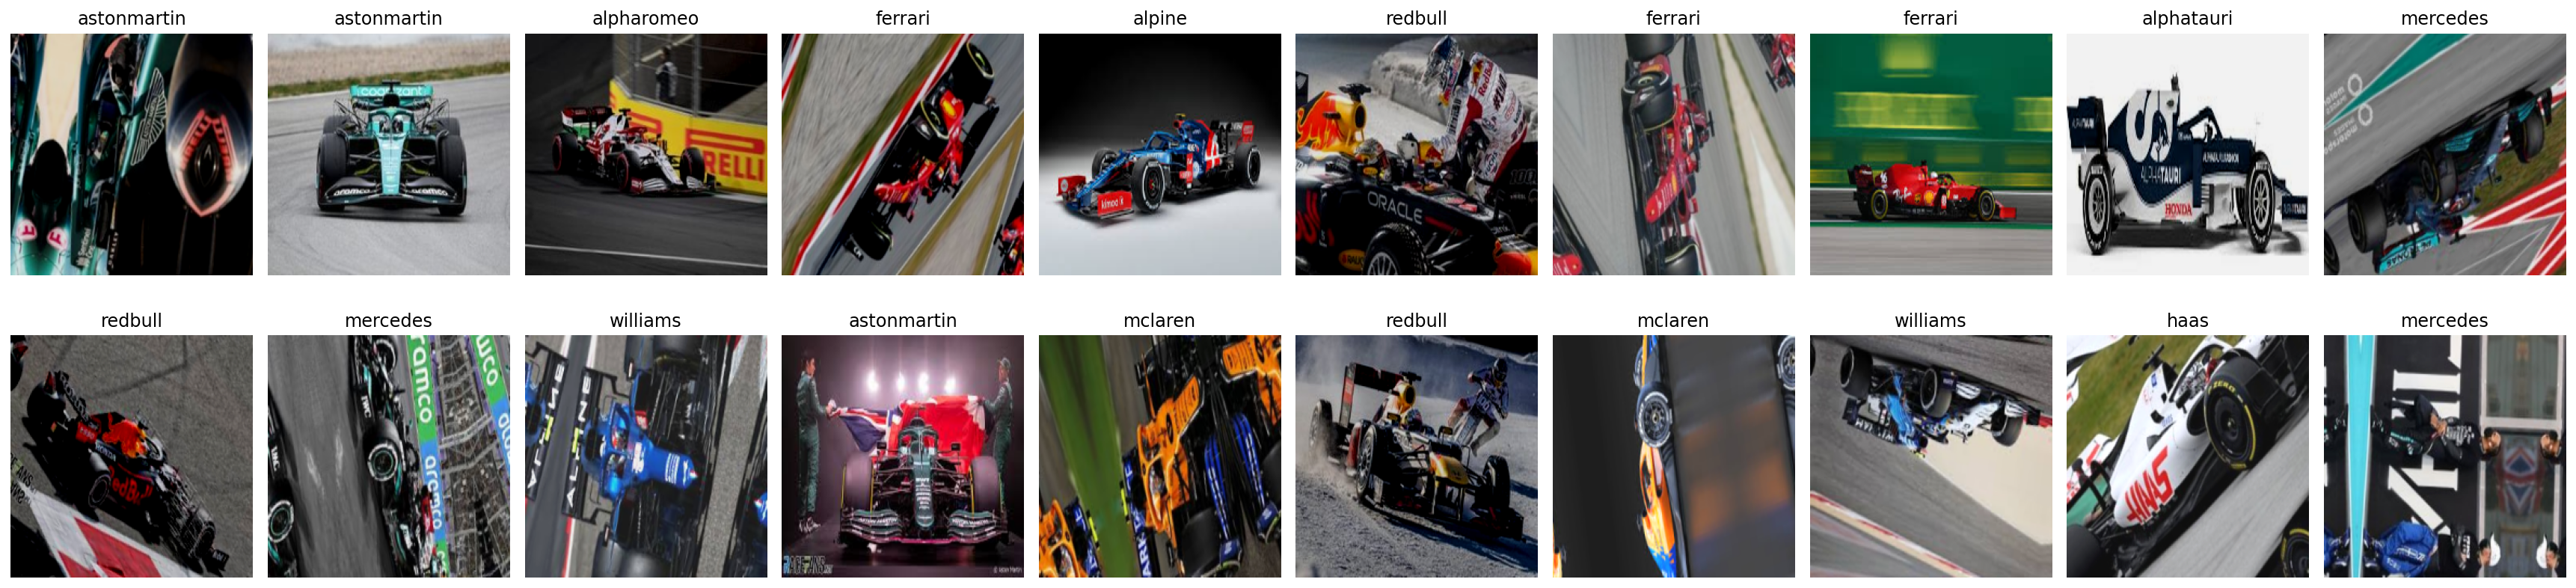

In [ ]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=20, cols=10, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 6))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

#Dataloaders
A classe DataLoader é usada para carregar dados em lotes para o modelo. Isso nos ajuda a processar dados em mini-lotes que podem caber na RAM da nossa GPU. Primeiro, importamos o DataLoader, em seguida inicamos o dataloader enviando um objeto do conjunto de dados e o tamanho do lote.

In [ ]:
#######################################################
#                  Define Dataloaders
#######################################################
from torch.utils.data import DataLoader
batch_size = 10

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

## Definição do Modelo

### Link para acesso ao modelo já treinado: https://drive.google.com/file/d/1vpHtglIr8_YukYhXWxDZur5HtXP_3k-K/view?usp=sharing


O modelo a seguir foi baseado nas arquiteturas da resnet, e da vgg19, duas das arquiteturas com maior sucesso no reconhecimento de imagens. 

Da Vgg19 utilizamos a idéia de a cada pool /x aplica-se uma saída x vezes a entrada, para tentar manter a complexidade dos parametros. 
Utilizamos também pools a cada quantidade x de camadas com a mesma quantidade de canais de saída

Da arquitetura resnet utilizamos sua esseência de se utilizar do valor residual para tentar evitar o gradiente de fuga, problema comum em redes mais profundas. Além de também utilizar o batch normalize na tentativa de diminuir a quantidade de épocas necessárias para treinar a rede. 

Por fim, foram testadas saídas completamente conectadas com 1, 2 e 3 camadas, sendo está ultima a que se apresentou com maior eficácia. 

Além de alguns dropouts para barrar o sobreajuste(overfetting) da rede

**Obs: ** A justificativa para a utilização do batch_normalize, pode ser vista em mais detalhes nestes links:

* https://arxiv.org/pdf/1502.03167.pdf
* https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
#Definindo algumas variáveis que irão auxiliar em alterações da configuração do modelo.
initial_input = 224
h = 512*7*7
header_2 = int((h)/4)
header_3 = int((h)/8)
header_4 = int((h)/16)
header_5 = int((h)/32)

out_channel_1 = 64
out_channel_2 = 128
out_channel_3 = 512

class Cnn_Net(nn.Module):
    def __init__(self):
        super(Cnn_Net,self).__init__()
            
        #Convolutional Layer
        self.conv0 = nn.Conv2d(3,out_channel_1,3,padding=1) # -> 224x224x64
        self.conv1 = nn.Conv2d(out_channel_1,out_channel_1,3,padding=1) # -> 224x224x64
        self.conv2 = nn.Conv2d(out_channel_1,out_channel_1,3,padding=1) # -> 224x224x64
        
        #Poll/2 -> 112x112x64
        self.conv3 = nn.Conv2d(out_channel_1,out_channel_2,3,padding=1) # ->112x112x128
        self.conv4 = nn.Conv2d(out_channel_2,out_channel_2,3,padding=1) # -> 112x112x128
        self.conv5 = nn.Conv2d(out_channel_2,out_channel_2,3,padding=1) # -> 112x112x128
       
        #Pool/4 -> 28x28x128
        self.conv6 = nn.Conv2d(out_channel_2,out_channel_3,3,padding=1) # -> 112x112x128
        self.conv7 = nn.Conv2d(out_channel_3,out_channel_3,3,padding=1) # -> 28x28x512
        self.conv8 = nn.Conv2d(out_channel_3,out_channel_3,3,padding=1) # -> 28x28x512
        self.conv9 = nn.Conv2d(out_channel_3,out_channel_3,3,padding=1) # -> 28x28x512
        self.conv10 = nn.Conv2d(out_channel_3,out_channel_3,3,padding=1) # -> 28x28x512
        self.conv11 = nn.Conv2d(out_channel_3,out_channel_3,3,padding=1) # -> 28x28x512
        #Pool/4 -> 7x7x512

        #Max_Pool
        self.pool1 = nn.MaxPool2d(2,2)
        self.pool2 = nn.MaxPool2d(4,4)

        #Batch_normalize
        self.batch_norm1 = nn.BatchNorm2d(out_channel_1)
        self.batch_norm2 = nn.BatchNorm2d(out_channel_2) 
        self.batch_norm3 = nn.BatchNorm2d(out_channel_3)

        #Fully_conected_layer
        self.c1 = nn.Linear(h,header_2)
        self.c2 = nn.Linear(header_2,header_3)
        self.c3 = nn.Linear(header_3,10)
        
        self.dropout = nn.Dropout(0.2)

            
    def forward(self,x):
        #Agora são implementadas as "shortcut connections", utilizadas para
        #tratar o gradiente de fuga
        x = F.relu(self.batch_norm1(self.conv0(x))) #Normalização das saídas da camada convolucional/inserção em uma função relu
        x1 = x #Captura o valor residual da primeira camada
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = (self.batch_norm1(self.conv2(x)))
        x += x1 #Aplica o valor residual a uma camada mais profunda -> O procedimento irá se repetir posteriormente
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.dropout(x)
        x = F.relu(self.batch_norm2(self.conv3(x)))
        x2 = x
        x = F.relu(self.batch_norm2(self.conv4(x)))
        x = self.batch_norm2(self.conv5(x))
        x += x2
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)

        x = F.relu(self.batch_norm3(self.conv6(x)))
        x3 = x
        x = F.relu(self.batch_norm3(self.conv7(x)))
        x = self.batch_norm3(self.conv8(x))
        x += x3
        x = F.relu(x)
        x = self.dropout(x)
       
        x = F.relu(self.batch_norm3(self.conv9(x)))
        x4 = x
        x = F.relu(self.batch_norm3(self.conv10(x)))
        x = self.batch_norm3(self.conv11(x))
        x += x4
        x = F.relu(x)
        x=self.pool2(x)
        x = self.dropout(x)
        
        #A rede tem entrado em overfetting, pode-se inserir dropouts na fully-connected-layer
        #Fully-connected_layer
        x = x.view(-1,h)
        x = F.relu(self.c1(x))
        x = self.dropout(x)
        x = F.relu(self.c2(x))
        x = self.dropout(x)
        x = self.c3(x)
       
        
        return x
    
model = Cnn_Net()
print(model)
if train_on_gpu:
    model.cuda()

Cnn_Net(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, pad

In [ ]:
#loss_function
import torch
criterion = torch.nn.CrossEntropyLoss()

#optimizer function
lr = 0.01
# optimizer = torch.optim.Adam(resnet.fc.parameters(), lr = lr)
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

### Treinamento do Modelo

In [ ]:
modelo = 'CNN_MODEL_v4_final_v2_n'
import numpy as np
# number of epochs to train the model
n_epochs = 50 # 70 you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss
train_loss_min = np.Inf
model_local_gDrive = '/content/drive/MyDrive/Raiz/Faculdade/2021.2/Deep Learning/Models/{}.pt'
model_local_kaggle = '/kaggle/working/{}.pt'
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()

    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if train_loss <= train_loss_min:
        train_loss_min = train_loss
        epoch_train_min = epoch
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        epoch_last_saved = epoch

        torch.save(model.state_dict(), model_local_gDrive.format(modelo))
        valid_loss_min = valid_loss

### Load do modelo treinado

In [ ]:
#Carrega o modelo salvo na época com menor error de validação
modelo = 'CNN_MODEL_V4_final_2'
caminho_modelo ='/content/drive/MyDrive/Raiz/Faculdade/2021.2/Deep Learning/Models/{}.pt'.format(modelo)
model.load_state_dict(torch.load(caminho_modelo))



<All keys matched successfully>

In [ ]:
print(model)

Cnn_Net(
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, pad

### Testando modelo

In [ ]:
# track test loss
def test_model(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  model.eval()
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      for i in range(batch_size):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
 
  # average test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

test_model(model)

Test Loss: 1.365893

Test Accuracy of williams:  8% ( 3/37)
Test Accuracy of ferrari: 62% (25/40)
Test Accuracy of alpine: 100% (55/55)
Test Accuracy of alphatauri: 82% (47/57)
Test Accuracy of redbull: 41% (16/39)
Test Accuracy of astonmartin:  3% ( 2/59)
Test Accuracy of  haas: 44% (22/50)
Test Accuracy of alpharomeo: 96% (53/55)
Test Accuracy of mercedes: 95% (47/49)
Test Accuracy of mclaren: 14% ( 7/49)

Test Accuracy (Overall): 56% (277/490)


### Confusion Matrix

In [ ]:
#Matria de confusão

def createCM(loader,model,nClasses):
    from sklearn.metrics import confusion_matrix
    model.cpu()
    accuracy = 0
    CM = np.zeros((nClasses,nClasses))
    y_pred = []
    y_real = []
    #COLOQUE O SEU CÓDIGO AQUI
    with torch.no_grad():
       for inputs, targets in loader:
          outputs = model(inputs)
          y_pred.extend((torch.max(outputs,1)[1]).numpy())
          y_real.extend(targets.numpy())
    CM = confusion_matrix(y_real,y_pred)
    values_correctly = 0
    for l in range(0,nClasses):
        values_correctly += CM[l][l]
    accuracy = ((100/CM.sum()) * values_correctly)
    #Para cada classe  procura os valores do tensor que sao dessa classe, posteriormente compara com o 




    return CM, accuracy

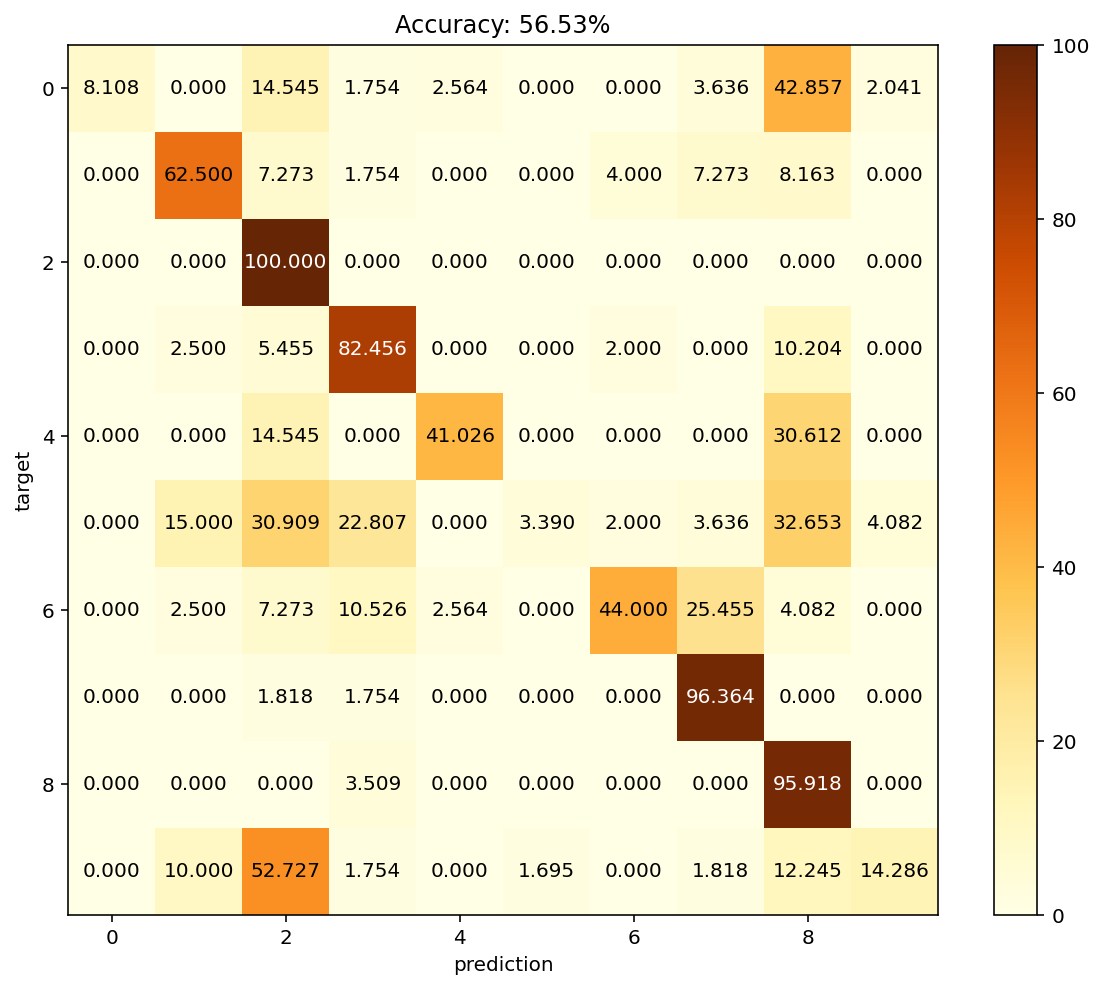

In [ ]:
#NÃO ALTERE ESTA CÉLULA
def plot_CM(CM,accuracy,name):

    CM = 100*CM/CM.sum(axis=1)
    plt.figure(figsize=(10,8))
    plt.imshow(CM,cmap='YlOrBr')
    plt.ylabel('target')
    plt.xlabel('prediction')
    plt.title('Accuracy: '+"{:4.2f}".format(accuracy)+'%')
    plt.colorbar()
    for i in range(CM.shape[0]):
        for j in range(CM.shape[1]):
            if CM[i,j]>70:
                color = "White"
            else:
                color = "Black"
            plt.text(j, i, "{:.3f}".format(CM[i,j]), ha="center", va="center", color=color)
    plt.savefig(name)

CM_test, accuracy_test = createCM(test_loader, model, 10)
plot_CM(CM_test, accuracy_test,'Test')

In [ ]:
CM_train, accuracy_train = createCM(train_loader, model, 10)
plot_CM(CM_train, accuracy_train,'Train')

In [ ]:
CM_validation, accuracy_validation = createCM(valid_loader, model, 10)
plot_CM(CM_validation, accuracy_validation,'Valid')